<img src="../style/img/vs265header.svg"/>

<h1 align="center">Lab 4 - Sparse, Distributed Representations</h1>

## Part 1 - Sparse Coding of Binary Patterns

In this problem you will implement Foldiak's model for learning features of binary data. Most of the code has been written for you, you only have to add the interesting parts - the dynamics, learning rules and statistics calculations.

We recommend that you read Foldiak's 1990 paper, <i>Forming Sparse Representations by Local Anti-Hebbian Learning</i>, before moving forward with this homework.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import utils.plotFunctions as pf
import utils.helperFunctions as hf

In [2]:
# Dataset generation
numDatapoints = 100 # Number of images in a batch
numInputs = 64 # Number of pixels in an image (must have integer sqrt)

# probabilityOn is used to determine, on average, what portion of the
# dataset has lines. It is also used to set the target output firing rate
# (num active / total num outputs) for the Foldiak model.
probabilityOn = 0.1

The `utils/helperFunctions.py` file contains a function called `genLines` that can be used to construct a binary line dataset. This is the same dataset as what is shown in Figure 2 of the Foldiak paper. The data contain a weighted random number of lines. The weighting is defined by the parameter probabilityOn. Check out the functin in utils/helperFunctions.py if you want to understand it better, or you can just run the code below and move on.

<IPython.core.display.Javascript object>


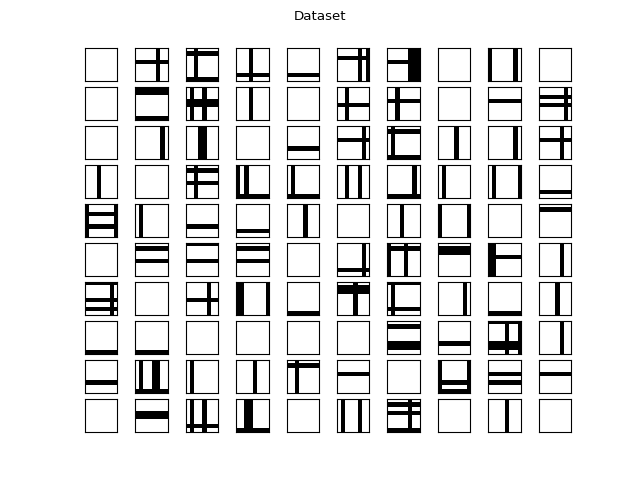

In [3]:
assert numInputs%np.sqrt(numInputs) == 0, (                                 
    "numInputs must have an integer square root") 

dataset = hf.genLines(numInputs, numDatapoints, probabilityOn)
pf.plotDataTiled(dataset, title="Dataset");

### 1.1 PCA

Our goal is to build a model that can learn the structure of this data. We know (because we made the data) that the basic building blocks of the data are a set of 16 lines, which can be combined and thresholded to make any of the images we see in our sample dataset.

A common first pass when modeling data is to perform linear PCA on the data, as you did in lab 3. If the data is linearly separable and drawn from a Gaussian distribution, then we should be able to use Hebbian learning rules to separate the individual building blocks, or causes, that combine to form the images in the dataset.

For this part of the problem, simply run the code cell below.

In [4]:
# Sanger's rule parameters
eta = 0.05 # Learning rate for Hebbian learning
numTrials = 4000 # Number of Hebbian learning steps to take
numOutputs = 16 # Number of neurons in the network layer

# Plot display parameters
displayInterval = 50 # How often to update display plots during learning

<IPython.core.display.Javascript object>


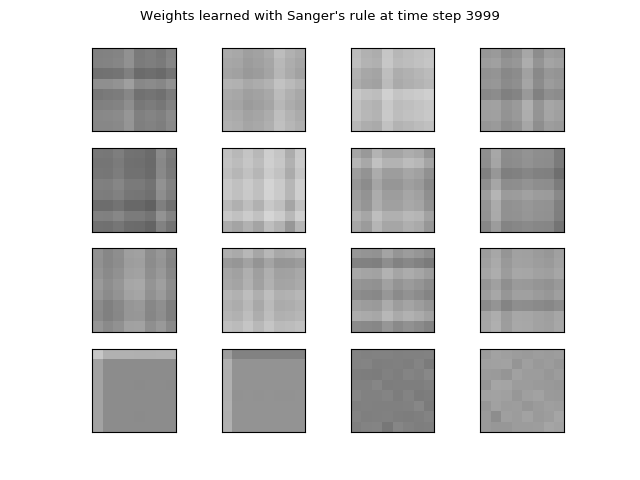

In [5]:
# Learn weights with Sanger's rule
weights = np.random.randn(numInputs, numOutputs)
prevFig = None
for trial in range(numTrials):
    dataset = hf.genLines(numInputs, numDatapoints, probabilityOn)
    learningRate = eta / numDatapoints # Batch normalization
    weights = hf.sangerLearn(dataset, weights, learningRate) 
    if trial % 1000 == 0:
        eta = eta * 0.8
    if trial % displayInterval == 0:
        prevFig = pf.plotDataTiled(weights, "Weights learned with Sanger's rule at time step "+str(trial), prevFig)

# Plot learned dictionary
prevFig = pf.plotDataTiled(weights, "Weights learned with Sanger's rule at time step "+str(trial), prevFig);

<b>YOUR ANSWER HERE:</b> What do you notice about the weights learned with Sanger's rule? Would you consider this an appropriate model of the generators of the data? Do you think a competitive network with a Winner-Take-All nonlinearity could model the data correctly? Why or why not?

The weights learned by Sanger's rule don't really resemble the structures in the actual dataset. They are blurred versions that can be combined linearly to approximate the dataset. However, it is not an appropriate model to generate the dataset because it doesn't capture the structure of the dataset which is not gaussian. A competitive network could model the data more correctly by capturing more of the underlying structure and finding the independent features of the dataset which seem like they should be vertical and horizontal bars.

### 1.2 Foldiak's Sparse Coding Model

Next we will try to learn the data's structure using Foldiak's network. This network attemps to learn redundancies in the data while preserving information. The original purpose of the network was to attempt to explain a possible principle of computation that may be occuring in the visual processing areas of the brain.

First we need to set our learning rates. With some patience and tinkering, you see that the network can learn to extract the independent lines that create the dataset. The learning rate for the feedforward weights, $\beta$, needs to be slower than those for the lateral weights, $\alpha$, and thresholds, $\gamma$. Why is this?

<b>YOUR ANSWER HERE:</b> Why should $\alpha$ and $\gamma$ change faster than $\beta$?

Alpha and gamma are the rates that drive lateral inhibition and individual node thresholds. If beta is much larger than these weights, you might expect activations to overpower decay and the entire network activity to saturate. Although to be honest I tried setting beta higher than both alpha and gamma and I didn't notice that happening.

In [20]:
eta = 0.001 # Foldiak dynamics time constant
numTrials = 1000 # Number of Foldiak learning steps to take
numOutputs = 16 # Number of neurons in the network layer

# Foldiak learning rates
alpha = 0.2 # YOUR CODE HERE # Lateral weights learning rate
beta =  0.1 # YOUR CODE HERE # Feedforward weights learning rate
gamma = 0.2 # YOUR CODE HERE # Threshold learning rate
averageEta = 0.1

# Plot display parameters
displayInterval = 50 # How often to update display plots during learning

In [21]:
def foldiakSparsify(dataset, forwardWeights, lateralWeights, thresholds, numTrials):
    (numInputs, numDatapoints) = dataset.shape
    numOutputs = forwardWeights.shape[1]
    numEdgePixels = np.sqrt(numInputs)
    
    y = np.zeros((numOutputs, numDatapoints)) # Network output
    
    # Activations are computed by projecting the dataset onto the feedforward weights
    activations = forwardWeights.T @ dataset # YOUR CODE HERE
    
    for trial in range(numTrials):
        # Run differential equation to allow network to settle to a solution
        # Hint: the 'thresholds' variable will need to be expanded. This can be done by using thresholds[:,None]
        # Hint: write the dynamics equation from the Folidak paper inside the hf.sigmoid() function
        dy = hf.sigmoid(forwardWeights.T @ dataset + lateralWeights @ y - thresholds[:,None]) - y # YOUR CODE HERE # Output dynamics
        y += eta * dy
        
    output = np.zeros((numOutputs, numDatapoints))
    output[np.where(y>0.5)] = 1
    
    return output

def foldiakLearn(dataset, activity, forwardWeights, lateralWeights, thresholds, alpha, beta, gamma):
    numDataPoints = dataset.shape[1]
    
    # Compute activation statistics (avg across datapoints)
    avgActivity = np.mean(activity, axis=1)
    corrOutOut = activity @ activity.T / numDataPoints # Average correlation of output neurons
    corrOutIn = dataset @ activity.T / numDataPoints # Average correlation between input and output
    
    # Update lateral weights (w in Foldiak paper)
    # Hint: use corrOutOut variable
    dw = -alpha * (corrOutOut - probabilityOn) # YOUR CODE HERE # lateral weight update rule
    lateralWeights += dw
    # Subtract Identity matrix so the units do not inhibit themselves
    lateralWeights -= np.diag(np.diag(lateralWeights))
    lateralWeights[np.where(lateralWeights>0)] = 0
    
    # Update feedforward weights (q in Foldiak paper)
    # Hint: use corrOutIn variable
    dq = beta * (corrOutIn - forwardWeights * avgActivity) # YOUR CODE HERE # feedforward weight update rule
    forwardWeights += dq
    
    # Update thresholds (t in Foldiak paper)
    dthresh = gamma * (avgActivity - probabilityOn) # YOUR CODE HERE # threshold update rule
    thresholds += dthresh
    
    return (forwardWeights, lateralWeights, thresholds)

<IPython.core.display.Javascript object>


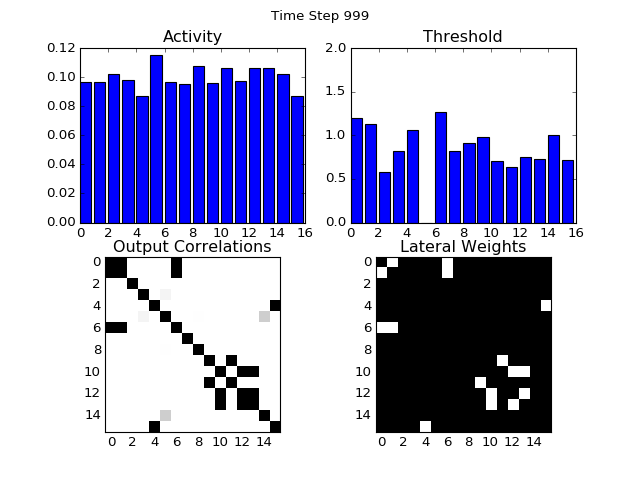

<IPython.core.display.Javascript object>


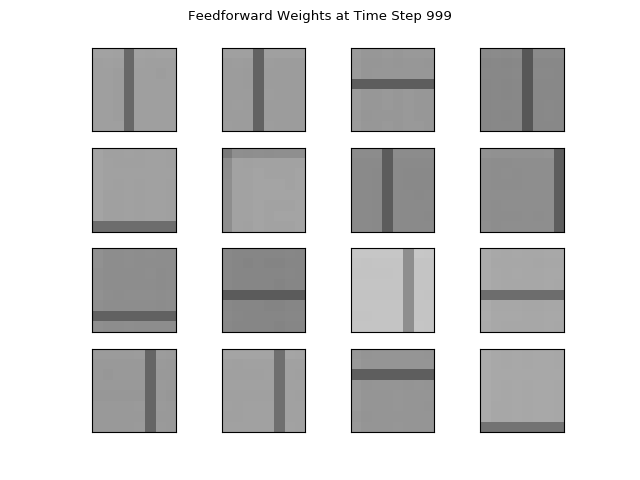

In [22]:
# Foldiak data structures
# Remember that numInputs, numOutputs, probabilityOn are all set above
forwardWeights = np.random.randn(numInputs, numOutputs)
lateralWeights = np.zeros((numOutputs, numOutputs))
thresholds = np.ones((numOutputs))
movingAverageActivity = probabilityOn
movingAverageCorrelation = probabilityOn**2

# Learn Foldiak model
prevFigs = [None, None]
for trial in range(numTrials):
    dataset = hf.genLines(numInputs, numDatapoints, probabilityOn)
    activity = foldiakSparsify(dataset, forwardWeights, lateralWeights, thresholds, numTrials)    
    (forwardWeights, lateralWeights, thresholds) = foldiakLearn(dataset, activity, forwardWeights, lateralWeights, thresholds, alpha, beta, gamma)
   
    # Store average correlation & activity for plotting
    activityMeans = np.mean(activity, axis=1)
    meanCenteredActivity = activity - activityMeans[:,None]
    movingAverageActivity = (1-averageEta) * movingAverageActivity + averageEta * activityMeans
    movingAverageCorrelation = (1-averageEta) * movingAverageCorrelation + averageEta * (meanCenteredActivity @ meanCenteredActivity.T / numDatapoints)
    
    if trial % displayInterval == 0:
        plotData = [movingAverageActivity, thresholds, movingAverageCorrelation, lateralWeights]
        prevFigs[0] = pf.plotFoldiak(plotData, "Time Step "+str(trial), prevFigs[0])
        prevFigs[1] = pf.plotDataTiled(forwardWeights, "Feedforward Weights at Time Step "+str(trial), prevFigs[1])

plotData = [movingAverageActivity, thresholds, movingAverageCorrelation, lateralWeights]  
prevFigs[0] = pf.plotFoldiak(plotData, "Time Step "+str(trial), prevFigs[0])
prevFigs[1] = pf.plotDataTiled(forwardWeights, "Feedforward Weights at Time Step "+str(trial), prevFigs[1])

<b>This next part is optional:</b> Now try using more and fewer than 16 output units, how does the network deal with these situations? You may need to modify your learning rates and `numTrials` to see a converged solution.

<IPython.core.display.Javascript object>


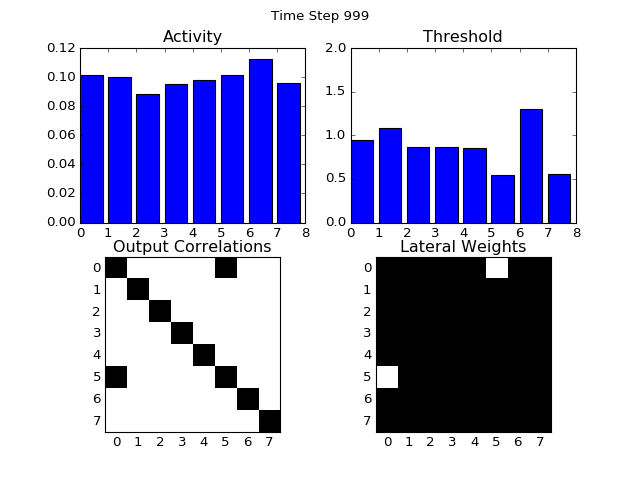

<IPython.core.display.Javascript object>


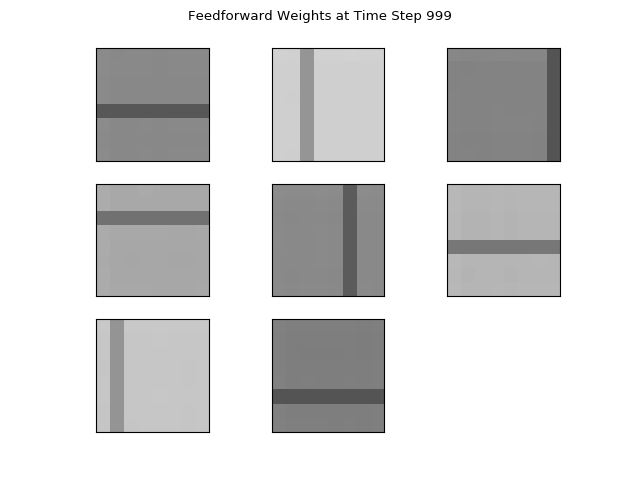

In [23]:
numOutputs = 8 # Number of neurons in the network layer

# Foldiak data structures
# Remember that numInputs, numOutputs, probabilityOn are all set above
forwardWeights = np.random.randn(numInputs, numOutputs)
lateralWeights = np.zeros((numOutputs, numOutputs))
thresholds = np.ones((numOutputs))
movingAverageActivity = probabilityOn
movingAverageCorrelation = probabilityOn**2

# Learn Foldiak model
prevFigs = [None, None]
for trial in range(numTrials):
    dataset = hf.genLines(numInputs, numDatapoints, probabilityOn)
    activity = foldiakSparsify(dataset, forwardWeights, lateralWeights, thresholds, numTrials)    
    (forwardWeights, lateralWeights, thresholds) = foldiakLearn(dataset, activity, forwardWeights, lateralWeights, thresholds, alpha, beta, gamma)
   
    # Store average correlation & activity for plotting
    activityMeans = np.mean(activity, axis=1)
    meanCenteredActivity = activity - activityMeans[:,None]
    movingAverageActivity = (1-averageEta) * movingAverageActivity + averageEta * activityMeans
    movingAverageCorrelation = (1-averageEta) * movingAverageCorrelation + averageEta * (meanCenteredActivity @ meanCenteredActivity.T / numDatapoints)
    
    if trial % displayInterval == 0:
        plotData = [movingAverageActivity, thresholds, movingAverageCorrelation, lateralWeights]
        prevFigs[0] = pf.plotFoldiak(plotData, "Time Step "+str(trial), prevFigs[0])
        prevFigs[1] = pf.plotDataTiled(forwardWeights, "Feedforward Weights at Time Step "+str(trial), prevFigs[1])

plotData = [movingAverageActivity, thresholds, movingAverageCorrelation, lateralWeights]  
prevFigs[0] = pf.plotFoldiak(plotData, "Time Step "+str(trial), prevFigs[0])
prevFigs[1] = pf.plotDataTiled(forwardWeights, "Feedforward Weights at Time Step "+str(trial), prevFigs[1])